In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [99]:
!pip3 install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 991.0 kB/s eta 0:01:41
   ---------------------------------------- 0.9/99.8 MB 11.0 MB/s eta 0:00:09
   ---------------------------------------- 1.0/99.8 MB 11.0 MB/s eta 0:00:09
   ---------------------------------------- 1.0/99.8 MB 11.0 MB/s eta 0:00:09
    --------------------------------------- 2.1/99.8 MB 10.2 MB/s eta 0:00:10
    --------------------------------------- 2.1/99.8 MB 10.2 MB/s eta 0:00:10
   - -------------------------------------- 2.7/99.8 MB 9.7 MB/s eta 0:00:10
   - -------------------------------------- 3.1/99.8 MB 10.6 MB/s eta 0:00:10
   - -------------------------------------- 3.1/99.8 MB 10.6 MB/s eta 0:00:10
   - ------------------

### EDA

In [2]:
data = pd.read_csv("Wholesale_customers_data.csv")
data.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [3]:
#check the number of rows and columns in the data
data.shape

(440, 8)

### Check the unique values in Channel and Region since they are nominal

In [4]:
data['Channel'].unique()

array([2, 1], dtype=int64)

In [5]:
data['Region'].unique()

array([3, 1, 2], dtype=int64)

In [6]:
data.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [7]:
#check the number of channels belonging to each category
data['Channel'].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

 ### Explore continuous features

In [8]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [9]:
#check for any missing value
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

#### Since the sum of missing values is 0, there are no missing values

In [10]:
data.corr()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


<Axes: >

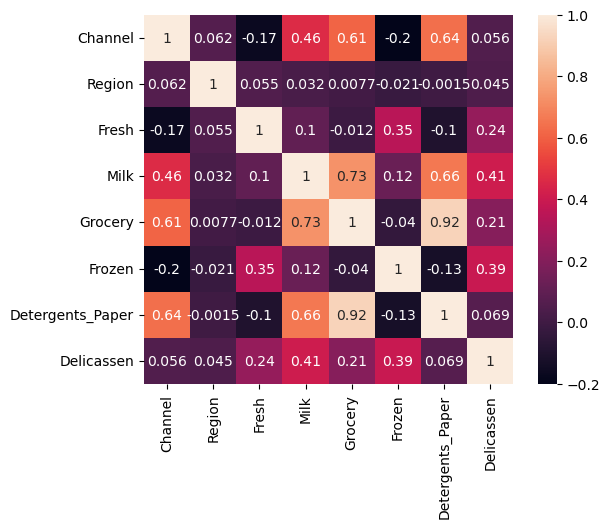

In [11]:
sb.heatmap(data.corr(), square=True, annot=True)

<li>There's a positive correlation of 0.64 between Channel and Detergents_Paper and negative correlation of -0.2 between Channel and Frozen</li>
<li> There's a huge positive correlation of 0.92 between Grocery and Detergent_Paper</li>
<li> There's a good amount of positive correlation of 0.73 between Milk and Grocery</li>


### Feature Scaling

In [12]:
features = data.iloc[:, 2:]

In [13]:
features

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


<Axes: ylabel='Density'>

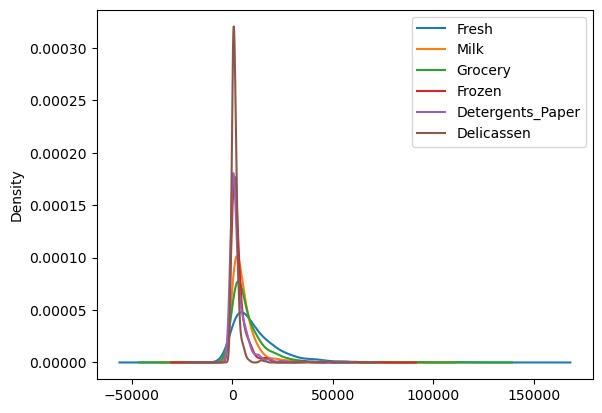

In [14]:
features.plot(kind='kde')

#### Standard Scaler

In [15]:
scaled_standard = StandardScaler().fit_transform(data)
scaled_standard

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

In [16]:
scaled_standard_dataframe = pd.DataFrame(scaled_standard, columns = data.columns)
scaled_standard_dataframe.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,4.400000e+02,4.400000e+02,440.000000,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,1.614870e-17,3.552714e-16,-3.431598e-17,0.000000,-4.037175e-17,3.633457e-17,2.422305e-17,-8.074349e-18
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-6.902971e-01,-1.995342e+00,-9.496831e-01,-0.778795,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-6.902971e-01,-7.023369e-01,-7.023339e-01,-0.578306,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-6.902971e-01,5.906683e-01,-2.767602e-01,-0.294258,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,1.448652e+00,5.906683e-01,3.905226e-01,0.189092,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,1.448652e+00,5.906683e-01,7.927738e+00,9.183650,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


<Axes: ylabel='Density'>

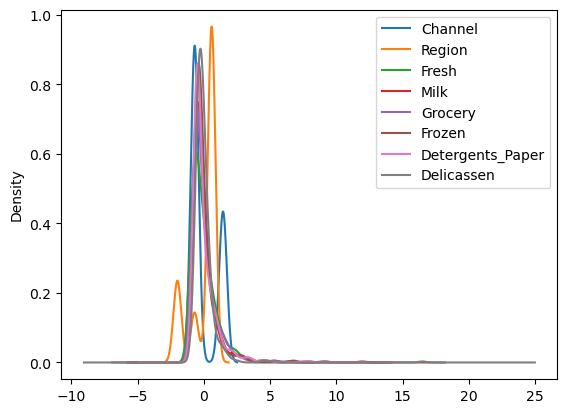

In [17]:
pd.DataFrame(scaled_standard_dataframe).plot(kind='kde')

#### MinMax Scaler

In [18]:
scaled_minmax = MinMaxScaler().fit_transform(data)
scaled_minmax

array([[1.00000000e+00, 1.00000000e+00, 1.12940044e-01, ...,
        3.10630465e-03, 6.54271997e-02, 2.78473091e-02],
       [1.00000000e+00, 1.00000000e+00, 6.28990263e-02, ...,
        2.85484189e-02, 8.05898491e-02, 3.69837297e-02],
       [1.00000000e+00, 1.00000000e+00, 5.66216072e-02, ...,
        3.91164289e-02, 8.60523222e-02, 1.63558615e-01],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.29543104e-01, ...,
        6.77141542e-03, 3.63462669e-01, 3.88819358e-02],
       [0.00000000e+00, 1.00000000e+00, 9.17270036e-02, ...,
        1.66491355e-02, 4.04174015e-03, 4.42636629e-02],
       [0.00000000e+00, 1.00000000e+00, 2.48243393e-02, ...,
        6.57418973e-04, 1.16108172e-02, 1.02211097e-03]])

In [19]:
scaled_minmax_dataframe = pd.DataFrame(scaled_minmax, columns = data.columns)
scaled_minmax_dataframe.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.322727,0.771591,0.106977,0.078173,0.085671,0.050078,0.070510,0.031745
std,0.468052,0.387136,0.112774,0.100491,0.102430,0.079789,0.116790,0.058826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.027863,0.020124,0.023174,0.011788,0.006216,0.008453
50%,0.000000,1.000000,0.075802,0.048636,0.051225,0.024670,0.019927,0.020077
75%,1.000000,1.000000,0.150968,0.097154,0.114821,0.058005,0.095997,0.037907
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: ylabel='Density'>

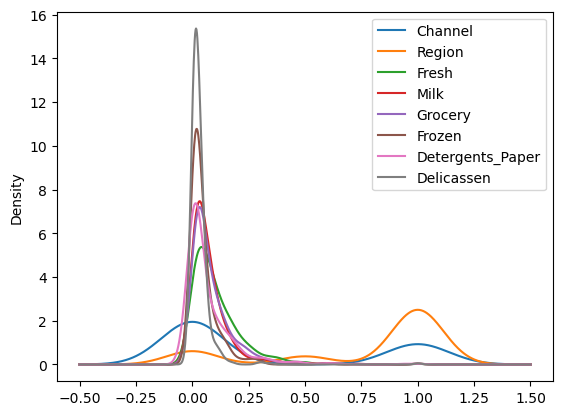

In [20]:
pd.DataFrame(scaled_minmax_dataframe).plot(kind='kde')

### Plotting for outlier detection

<Axes: >

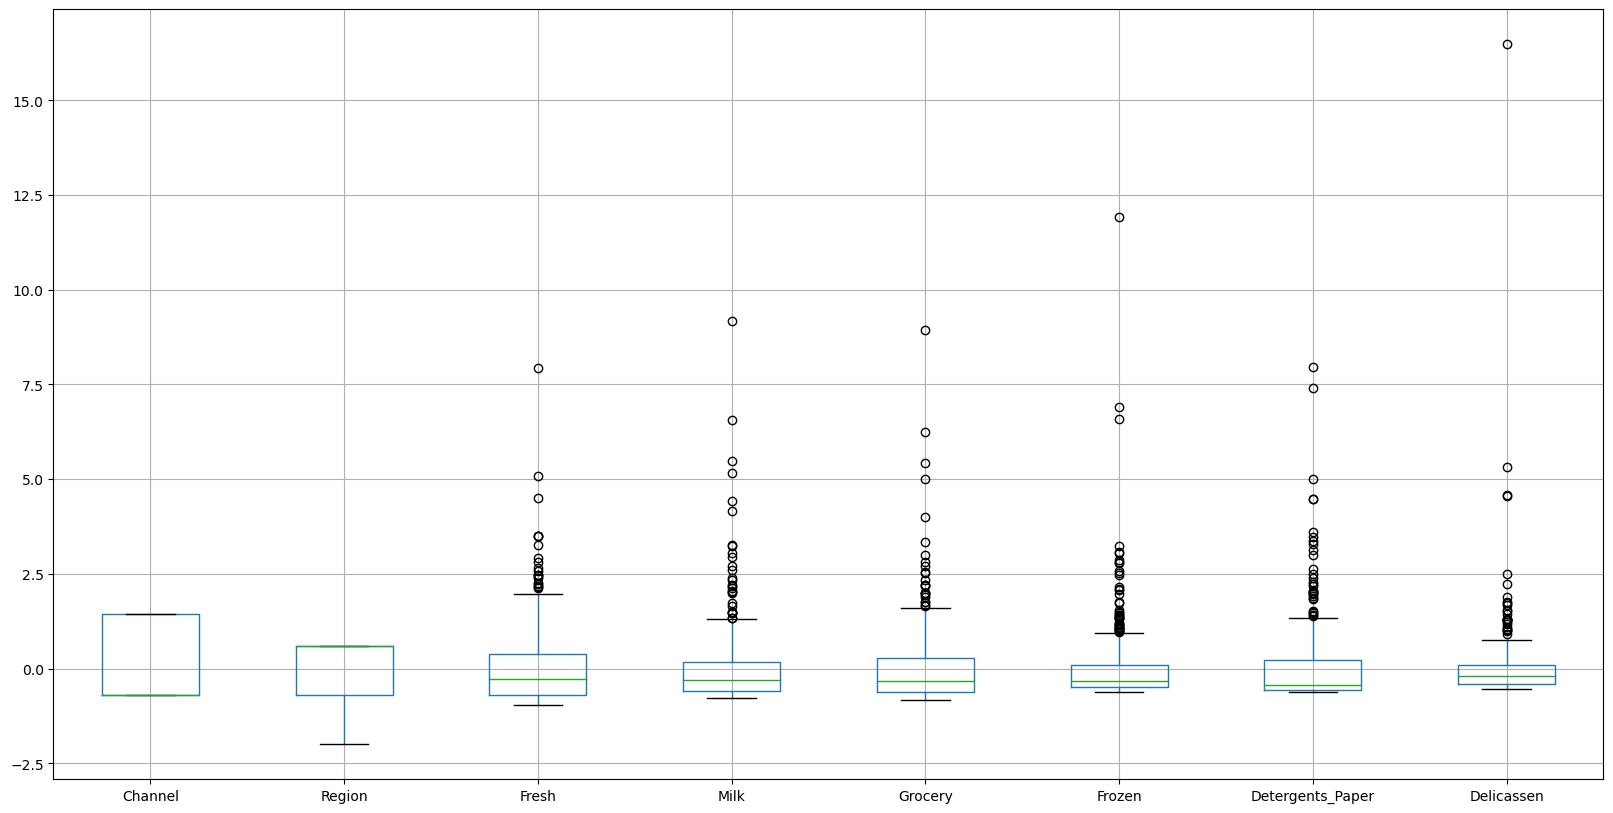

In [21]:
fig = plt.figure(figsize=(20,10))
scaled_standard_dataframe.boxplot(column = [col for col in list(scaled_standard_dataframe)])

<Axes: >

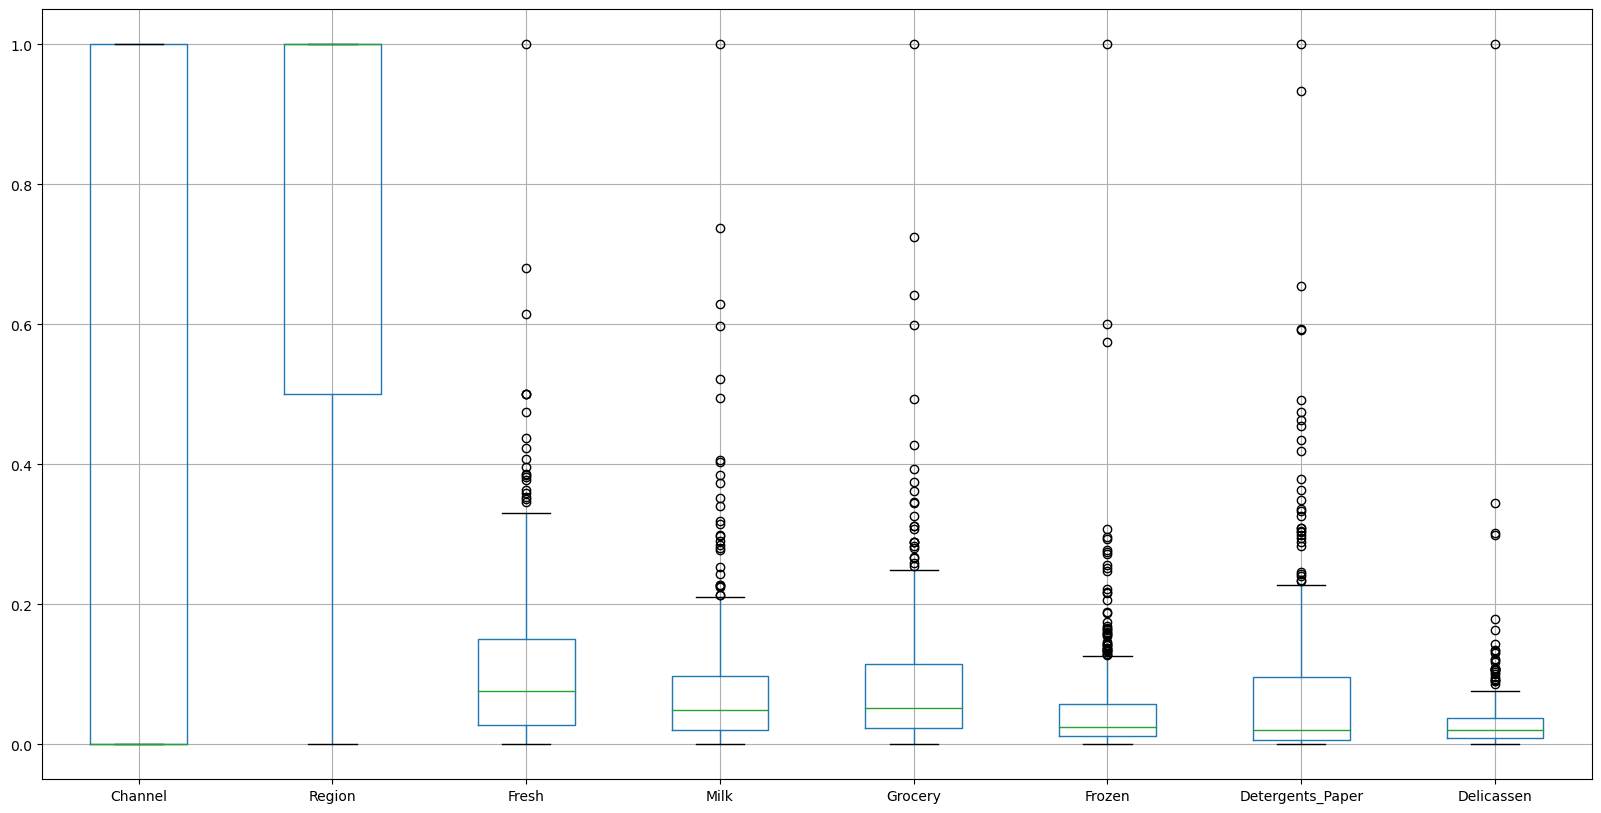

In [22]:
fig = plt.figure(figsize=(20,10))
scaled_minmax_dataframe.boxplot(column = [col for col in list(scaled_minmax_dataframe)])

#### Observation:
Scaling the data using StandardScaler method bought the data into uniform units across all the columns. Because of this scaling, each feature will now have almost equal weight and will be considered equally important without any bias and hence it becomes easier for the model to make predictions. 
Scaling the data using MinMaxScaler method also bought the data into uniform units across all the columns. As we can see for data using MinMaxScaler, the range of values are between [0,1]. MinMaxScaler works well if the data is not normally distributed(Gaussian). Comparatively, there are a lot of outliers in MinMaxScaler and since the data is normally distributed, we'll be choosing StandardScaler in the further predictions.

In [23]:
features.head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
7,7579,4956,9426,1669,3321,2566
8,5963,3648,6192,425,1716,750
9,6006,11093,18881,1159,7425,2098


array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

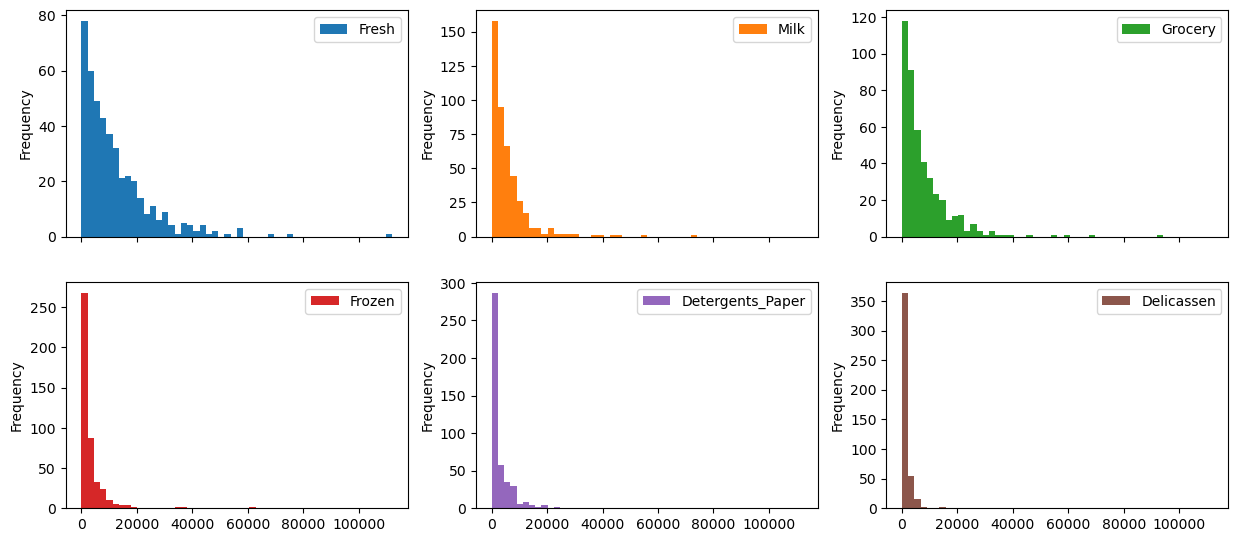

In [24]:
features.plot(kind='hist', bins=50, subplots=True, layout=(3,3), legend=True, figsize=(15,10))

#### The histograms show an exponential decline in the number of orders for the respected products. Hence this could be a cluster consisting of larger size companies with higher purchase quanitites for these particular items.

### RFECV

In [25]:
X = scaled_standard_dataframe.drop(['Channel'], axis=1)
#since Channel is our target variable
Y = data['Channel']
Y[Y == 1] = 1
Y[Y == 2] = 0
Y.value_counts()

Channel
1    298
0    142
Name: count, dtype: int64

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [28]:
print("Linear Regression: ", LinearRegression().fit(X_train, Y_train).score(X_test, Y_test))
print("K-Nearest Neighbors: ", KNeighborsClassifier().fit(X_train, Y_train).score(X_test, Y_test))
print("Support Vector Classifier: ", SVC().fit(X_train, Y_train).score(X_test, Y_test))
print("Gradient Boosting Classifier: ", GradientBoostingClassifier().fit(X_train, Y_train).score(X_test, Y_test))
print("Random Forest Classifier: ", RandomForestClassifier().fit(X_train, Y_train).score(X_test, Y_test))

Linear Regression:  0.464938511811836
K-Nearest Neighbors:  0.8909090909090909
Support Vector Classifier:  0.8818181818181818
Gradient Boosting Classifier:  0.9090909090909091
Random Forest Classifier:  0.9


#### Since Gradient Boosting Classifier is giving the best accuracy score of all, we will be use Gradient Boosting Classifier as the estimator for RFECV

In [29]:
rfecv = RFECV(estimator=GradientBoostingClassifier())
rfecv.fit(X, Y)


RFECV(estimator=GradientBoostingClassifier())

In [30]:
rfecv.cv_results_

{'mean_test_score': array([0.88636364, 0.90681818, 0.90681818, 0.90681818, 0.92045455,
        0.90909091, 0.89090909]),
 'std_test_score': array([0.01016395, 0.02317736, 0.02530802, 0.02426609, 0.01607061,
        0.01607061, 0.04906144]),
 'split0_test_score': array([0.875     , 0.90909091, 0.88636364, 0.90909091, 0.92045455,
        0.93181818, 0.93181818]),
 'split1_test_score': array([0.89772727, 0.90909091, 0.88636364, 0.875     , 0.89772727,
        0.88636364, 0.89772727]),
 'split2_test_score': array([0.875     , 0.93181818, 0.93181818, 0.92045455, 0.93181818,
        0.92045455, 0.79545455]),
 'split3_test_score': array([0.88636364, 0.92045455, 0.94318182, 0.94318182, 0.94318182,
        0.89772727, 0.92045455]),
 'split4_test_score': array([0.89772727, 0.86363636, 0.88636364, 0.88636364, 0.90909091,
        0.90909091, 0.90909091])}

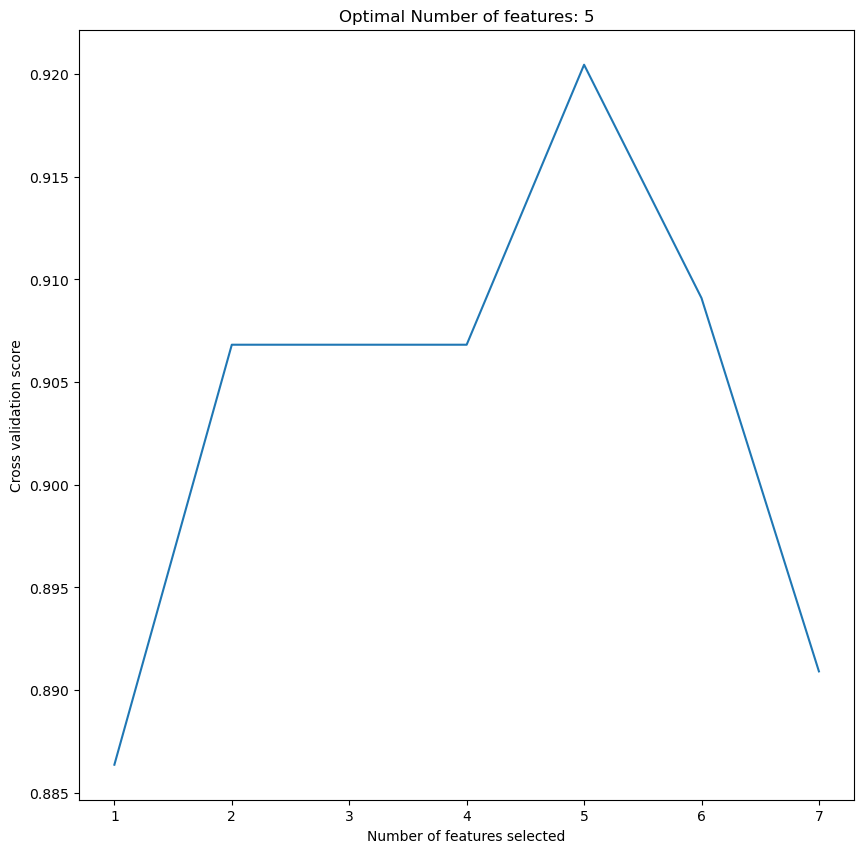

In [31]:
n_scores = len(rfecv.cv_results_['mean_test_score'])
plt.figure(figsize=(10,10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, n_scores+1), rfecv.cv_results_['mean_test_score'])
plt.title("Optimal Number of features: {}".format(rfecv.n_features_))
plt.show()

#### K-Means for 2 to 15 clusters

In [32]:
wcss = []
for i in range(2,16):
    clustering = KMeans(n_clusters=i, random_state=5)
    clustering.fit(scaled_standard)
    wcss.append(clustering.inertia_)

In [33]:
wcss

[2599.3873849123083,
 2149.283956221759,
 1851.7595764506573,
 1547.092741153285,
 1313.961987424017,
 1191.0653549805397,
 1064.9511210223977,
 979.1114496637405,
 913.4639657997401,
 851.7041522431481,
 803.4009723994486,
 777.1657522570288,
 721.0902919400475,
 686.7440851024853]

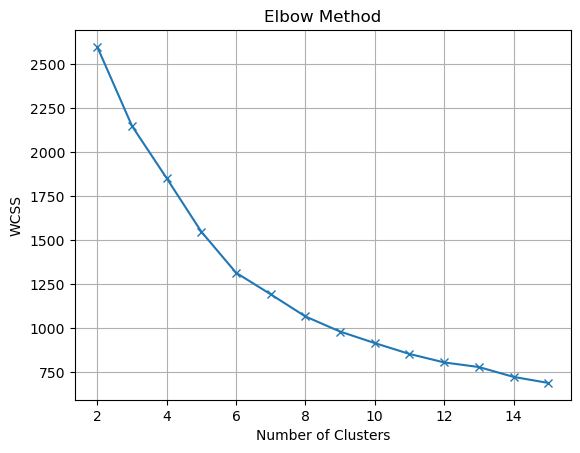

In [35]:
plt.plot(list(range(2,16)), wcss, marker='x')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

#### Observation:
In the above graph, the elbow point comes at around number of clusters(n)=6 which will be the optimal number of clusters for the above data. After n=6, as we keep on increasing the number of clusters, the wcss decreases slightly.
Hence, the optimal number of clusters=6

In [36]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scaled_standard_dataframe)

KMeans(n_clusters=6)

In [37]:
print('Sum of the squared error: {}'.format(kmeans.inertia_))
print('Centroids: {}'.format(kmeans.cluster_centers_))

Sum of the squared error: 1314.1997560278032
Centroids: [[ 1.44865163e+00  1.69928497e-01 -3.14722179e-01  4.52466342e-01
   6.66146634e-01 -3.51066687e-01  6.83203927e-01  4.65876480e-02]
 [-5.95232699e-01  3.03333796e-01  1.85960912e+00 -1.24058137e-01
  -2.57815536e-01  1.46400382e+00 -4.26267584e-01  4.13676499e-01]
 [-6.90297086e-01  5.90668285e-01  1.96681731e+00  5.17550306e+00
   1.28721685e+00  6.90059988e+00 -5.54861977e-01  1.64784475e+01]
 [-5.90811099e-01 -1.58939862e+00 -1.17369902e-01 -3.50992288e-01
  -4.02741180e-01  1.33513200e-02 -4.22747572e-01 -1.62015752e-01]
 [-6.90297086e-01  5.90668285e-01 -2.26969330e-01 -3.81612608e-01
  -4.75234627e-01 -1.72435121e-01 -4.42861386e-01 -1.86419955e-01]
 [ 1.44865163e+00 -5.58343155e-02  3.13830315e-01  3.92190593e+00
   4.27561037e+00 -3.57419457e-03  4.61816580e+00  5.03365339e-01]]


In [38]:
pd.Series(kmeans.labels_).value_counts()

4    172
0    126
3     86
1     45
5     10
2      1
Name: count, dtype: int64

#### PCA with 2 components

In [39]:
pca = PCA(n_components=2)
wholesale_data_pca_2 = pca.fit_transform(scaled_standard_dataframe)

In [40]:
pca.explained_variance_ratio_

array([0.38750123, 0.22374588])

#### Variance of 1st component is 38.75% and 2nd component is 22.37% i.e The principal component 1 holds 38.75% of the information whereas the principal component 2 holds 22.37% of the information.

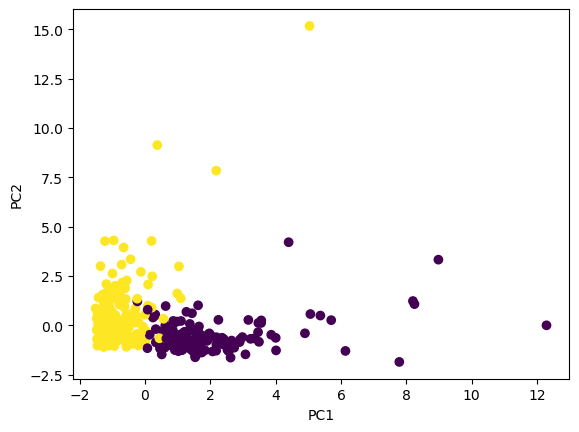

In [42]:
plt.scatter(wholesale_data_pca_2[:,0], wholesale_data_pca_2[:,1], c=data['Channel'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### PCA with 4 components

In [43]:
pca = PCA(n_components=4)
wholesale_data_pca_4 = pca.fit_transform(scaled_standard_dataframe)

In [44]:
pca.explained_variance_ratio_

array([0.38750123, 0.22374588, 0.12647173, 0.09229904])

#### Variance of 1st component is 38.75%,  2nd component is 22.37%, 3rd  component has 12.64% and 4th component has 9.22% i.e The principal component 1 holds 38.75% of the information, the principal component 2 holds 22.37% of the information, component 3 holds 12.64% and component 4 holds 9.22% of information.

In [45]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=100)
y_means = kmeans.fit(scaled_standard_dataframe)

In [46]:
scaled_standard_dataframe

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,1.448652,0.590668,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,1.448652,0.590668,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,-0.690297,0.590668,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,1.448652,0.590668,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
...,...,...,...,...,...,...,...,...
435,-0.690297,0.590668,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091
436,-0.690297,0.590668,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501
437,1.448652,0.590668,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,-0.690297,0.590668,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046


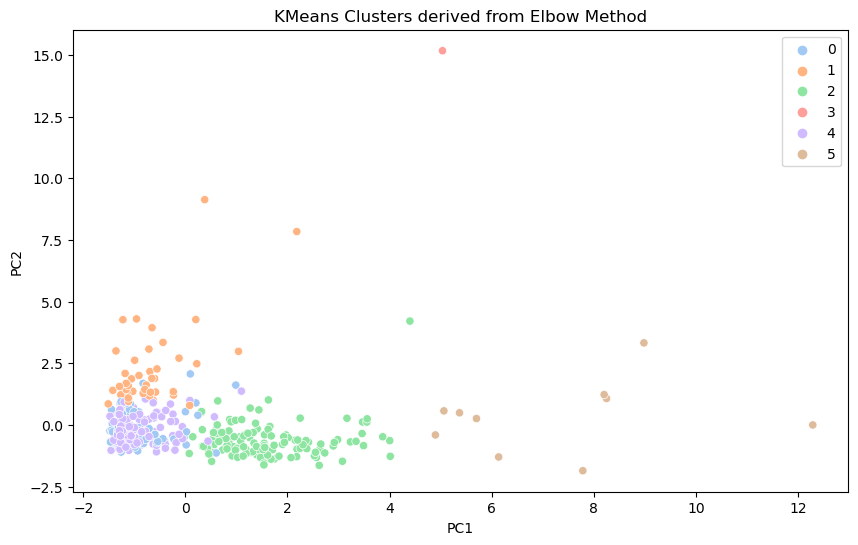

In [47]:
plt.figure(figsize=(10,6))
sb.scatterplot(x=wholesale_data_pca_4[:,0], y=wholesale_data_pca_4[:,1], hue=y_means.labels_, palette='pastel', data=scaled_standard_dataframe).set_title("KMeans Clusters derived from Elbow Method")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### XGBoost Classifier

In [48]:
X = data.drop('Channel', axis=1)

In [49]:
Y = data['Channel']

In [50]:
Y[Y == 2] = 0
Y[Y == 1] = 1

In [51]:
X.head(10)

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3,12669,9656,7561,214,2674,1338
1,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
3,3,13265,1196,4221,6404,507,1788
4,3,22615,5410,7198,3915,1777,5185
5,3,9413,8259,5126,666,1795,1451
6,3,12126,3199,6975,480,3140,545
7,3,7579,4956,9426,1669,3321,2566
8,3,5963,3648,6192,425,1716,750
9,3,6006,11093,18881,1159,7425,2098


In [52]:
Y.head(10)

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: Channel, dtype: int64

In [53]:
#Since it is a classification task, we will use logloss as evaluation metric
xgbc = XGBClassifier(eval_metric='logloss')
kfold = KFold(n_splits=5)
result = cross_val_score(xgbc, X, Y, cv=kfold)

In [54]:
print('Accuracy Score: {}%'.format(result.mean()*100))

Accuracy Score: 92.04545454545455%


In [55]:
print('Standard Deviation: {}%'.format(result.std()*100))

Standard Deviation: 3.3709993123162114%


In [56]:
Precision_Score = cross_val_score(xgbc, X, Y, cv=kfold, scoring='precision_weighted')
Recall_Score = cross_val_score(xgbc, X, Y, cv=kfold, scoring='recall_weighted')

In [57]:
print('Precision Score: {}%'.format(Precision_Score.mean()*100))

Precision Score: 92.72498120032316%


In [58]:
print('Recall Score: {}%'.format(Recall_Score.mean()*100))

Recall Score: 92.04545454545455%


In [59]:
P = (Precision_Score.mean())*100
R = (Recall_Score.mean())*100

In [60]:
F1_Score = 2*(P*R)/(P+R)

In [61]:
print('F1 Score: {}%'.format(F1_Score))

F1 Score: 92.38396833187647%
